# Импорт необходимых библиотек

In [1]:
import wget

import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import Dataset

%matplotlib inline

# Исследовательский анализ данных

## Загрузка датасета

In [3]:
import os

if not os.path.exists('geo-reviews-dataset-2023.tskv'):
    dataset = wget.download('https://github.com/yandex/geo-reviews-dataset-2023/raw/refs/heads/master/geo-reviews-dataset-2023.tskv?download=')
    print('Датасет был загружен')
else:
    print('Датасет уже есть на диске')

Датасет уже есть на диске


In [4]:
# Считаем при помощи pandas исходный файл с табуляцией в качестве разделителя, задав нужные нам имена колонок
df = pd.read_csv('geo-reviews-dataset-2023.tskv', sep='\t', header=None, names=['address', 'name_ru', 'rating', 'rubrics', 'text'])
columns = df.columns.to_list()
# Пройдем в цикле по колонкам и удалим из ячеек ключи
for column in columns:
    df[column] = df[column].replace(f'{column}=', '', regex=True)

In [5]:
# Посмотрим на результат
df.head(5)

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


In [6]:
# Размер дата фрейма
df.shape

(500000, 5)

In [7]:
df.dtypes

address    object
name_ru    object
rating     object
rubrics    object
text       object
dtype: object

In [8]:
# Количество уникальных значений
df.nunique()

address    191925
name_ru    148461
rating        393
rubrics     32694
text       498918
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  500000 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


Видим, что в нашей ДатаФрейме есть пропущенные значение в колонке "text". Удалим их

In [10]:
df = df.dropna(ignore_index=True)

In [11]:
num_duplicates = df.duplicated().sum()
num_duplicates

np.int64(1)

Выведем на экран

In [12]:
df.loc[df.duplicated(keep=False), :]

,address,name_ru,rating,rubrics,text
123882,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."
123884,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."


Видим, что в колонке 'rating' после цифры идёт точка. Уберём её. Приведём к типу int64

In [13]:
df['rating'] = df['rating'].replace('\.', '', regex=True)
df['rating'] = pd.to_numeric(df['rating'])

Посмотрим на баланс классов в колонке 'rating', построив гистограмму

<Axes: xlabel='rating', ylabel='Count'>

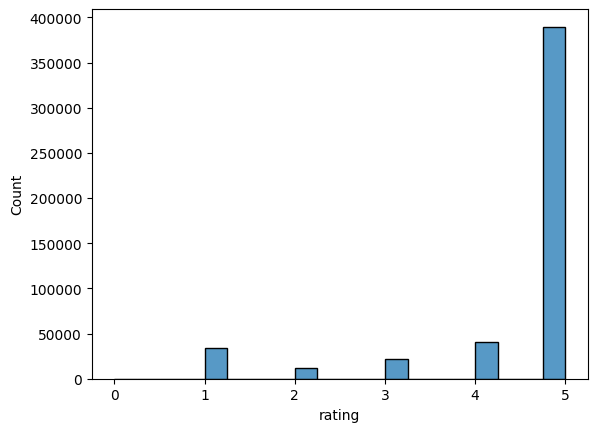

In [14]:
sns.histplot(df['rating'])

Из этого видно, что с рейтингом 5 сильно больше остальных. Причём с рейтингом 0 практически нет.
Посмотрим что из себя представляют отзывы с рейтингом 0

In [15]:
df.query('rating==0')

,address,name_ru,rating,rubrics,text
1906,"Республика Карелия, Суоярви, улица Шельшакова, 1",Гостиница Карелия,0,Гостиница,"Гостиница расположенна удобно, если отремонтир..."
2164,"Кемерово, улица Тухачевского, 12",Светофор,0,Магазин автозапчастей и автотоваров;Автоаксесс...,Это мой любимый магазин с запчастями. Можно вс...
3583,"Краснодарский край, Анапа, улица Пушкина, 30",Кубань,0,Санаторий,"Нет растительного масла для салата, нет зубочи..."
3614,"Краснодарский край, Туапсинский район, Новомих...",Счастливый Хотей,0,Гостиница,"Все довольны, и взрослые и дети.\nВкусная еда...."
6384,"Ленинградская область, Выборг, улица Мира, 8А",Атриум,0,Торговый центр,"Большой выбор, очень грамотно и удобно разложе..."
...,...,...,...,...,...
481104,"посёлок городского типа Сириус, Набережная ули...",Ем и ем,0,Столовая;Быстрое питание;Доставка еды и обедов,Отличная столовая ходим переодически по сравне...
482537,"Кабардино-Балкарская Республика, Нальчик, улиц...",Амбассадор,0,Ресторан;Доставка еды и обедов,На днях посетили с семьёй ресторан Амбассадор....
485989,"Свердловская область, Екатеринбург, улица Цвил...",Рими,0,Мебель для кухни;Мебель на заказ;Гардеробные с...,Кухни европейского качества. Хорошее обслужива...
494291,"Санкт-Петербург, Полтавская улица, 3",Добрый Грузин,0,Ресторан;Доставка еды и обедов;Банкетный зал,"Очень вкусно готовят. Мясо шикарное, шашлык, х..."


В дальнейшем нам необходимо провести баланс классов. Есть шум в виде отзывов на 0, но сами отзывы по большей части являются положительными, что может сказать на качестве модели

Добавим в наш датафрейм колонку, в которой будет указана длина отзыва и проанализируем полученный результат.

In [16]:
df['review_length'] = df['text'].str.len()

In [17]:
# Выведем статистические характеристики этой колонки
df['review_length'].describe()

count    499030.000000
mean        303.232533
std         292.609661
min           2.000000
25%         145.000000
50%         215.000000
75%         365.000000
max       20162.000000
Name: review_length, dtype: float64

<Axes: xlabel='review_length', ylabel='Count'>

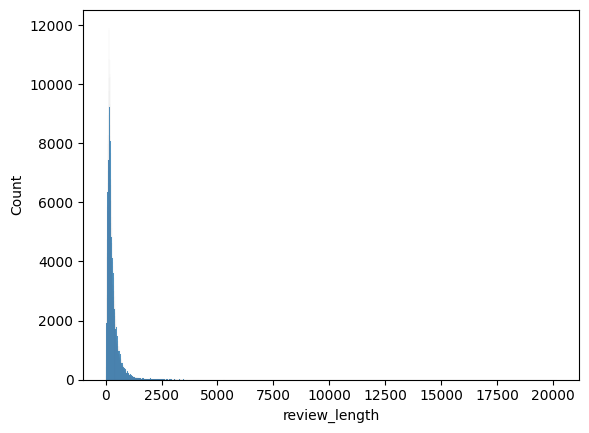

In [18]:
# Построит гистограмму распределения значений в столбце review_length датафрейма df
# Она показывает, как часто встречаются различные значения длины отзыва
sns.histplot(df['review_length'])

<Axes: ylabel='review_length'>

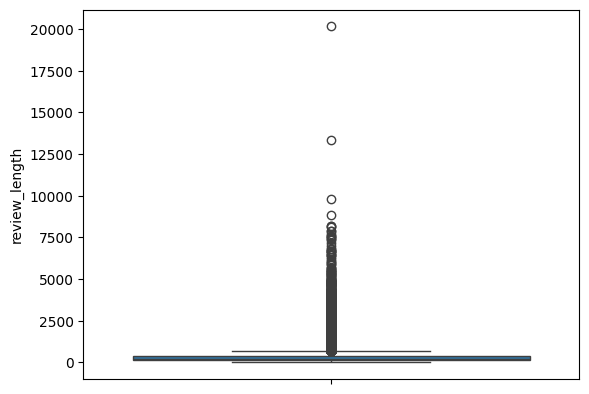

In [19]:
sns.boxplot(df['review_length'])

Посмотрим на самые длинные и на самые короткие отзывы

In [20]:
df.query('review_length > 10000')['text'].values

array(['Que si, que no...\\nМногажды бывал в этом замечательном отеле, и с каждым разом всё больше и больше эта песня про тупящего влюблённого, являющаяся гимном отеля, всё точнее и точнее описывает качество отдыха. Вообще, этот гимн противоречиям максимально отражает происходящее с Вами на отдыхе в Ялта Интурист.\\nНачинается знакомство с особенностями сервиса со службы размещения (это те, кого называют ресепшн). Приветливость сотрудников на стойке регистрации можно выделить отдельно, Вас всегда встретят с улыбкой, всё расскажут и ответят на Ваши вопросы при заселении, но на чемпионате мира по созданию очередей, они без особого труда возьмут второе место (первое – без шансов конкурентам у транспортной безопасности терминала Аэроэкспресс в Шереметьево). Специальный удобный трансфер быстро перемещает десятки гостей из аэропорта и вокзала в очередь на заселение, где на 6 стойках регистрации работают всего один или два сотрудника. Господа, это, же, элементарно: на время прибытия трансферо

In [21]:
df.query('review_length < 10')['text'].values

array(['Круто', 'Круто', 'кайф\\n', 'Все круто', 'Отлично ', 'Отлично!',
       'Прилично ', 'Лучшие!', 'Клас!', 'Класс', 'Хорошо ', 'Удобно',
       'Супер', 'Не плохо ', 'Нормально', 'Спасибо!', 'Отлично',
       'Спасибо', 'Норм', 'Стандарт.', 'Чисто!', 'Все отл', 'Удобно',
       'Хорошо', '10 из 10', 'Ок', 'Вкусно', 'Супер', 'Норм', 'Вкусно',
       'Красавцы', 'Не вкусно', 'Все норм.', 'Профи!', 'Отлично.',
       'Круть', 'Чисто', 'Отлично.', 'Хорошо ', 'Бомба', 'Всё супер',
       'топ топ', 'Норм', 'Вполне!', 'Всё чëтко', 'Вкусно', 'Класс! '],
      dtype=object)

Из этого можно сделать, что слишком короткие и слишком длинные отзывы бессмыслены. Считаем их за выброс и удаляем

In [22]:
df_cor = df[['rating', 'review_length']]
df_cor

,rating,review_length
0,3,537
1,5,158
2,1,485
3,4,142
4,5,373
...,...,...
499025,5,76
499026,4,295
499027,4,325
499028,5,502


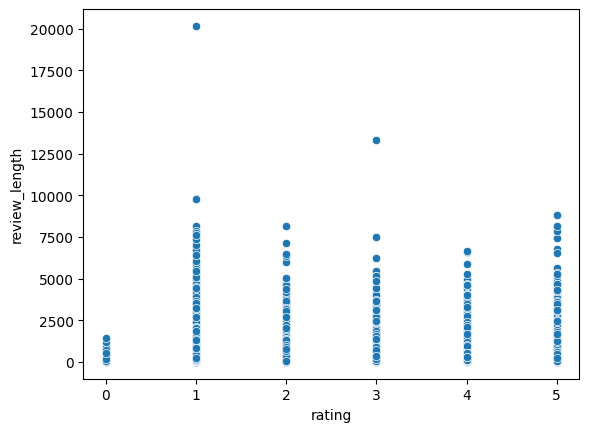

In [23]:
sns.scatterplot(x ='rating', y = 'review_length', data=df_cor)
plt.show()

Построим корреляционную матрицу

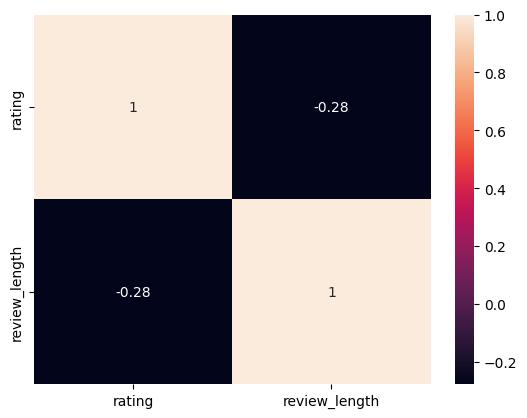

In [24]:
corr_matrix = df_cor.corr()

sns.heatmap(corr_matrix, annot=True)
plt.show()

Значение корреляции -0.28 указывает на слабую обратную (отрицательную) корреляцию между двумя переменными 

In [25]:
# Сохраним наш датафрейм в tsv файл для дальнейшей работы
df.to_csv('geo-reviews-dataset-2023.tsv', sep='\t', index=False)

# Расчет частотности слов

In [26]:
# Соберем все тексты отзывов в одну строку
words_list_list = df['text'].to_list()
words_str = ' '.join(str(string) for string in words_list_list)

### Удалим из строки все спец.символы

In [27]:
def remove_chars_from_text(text, chars):
    return "".join([char for char in text if char not in chars])

spec_chars = string.punctuation + '\n\xa0«»\t—…n'

text = remove_chars_from_text(words_str, spec_chars)
text = remove_chars_from_text(text, string.digits)

# Приведем все слова к нижнему регистру
text = text.lower()

In [28]:
# Токенизируем текст
nltk.download('punkt_tab')
text_tokens = word_tokenize(text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Burn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Посмотрим статистику по неочищенным словам

In [29]:
text = nltk.Text(text_tokens)
fdist = FreqDist(text)

In [30]:
print('Статистика по неочищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по неочищенным словам

Всего слов: 21306636

Уникальных слов: 742932

Топ-10 слов по частоте: 
и:  874480
в:  604858
не:  400240
на:  389339
очень:  298972
с:  289708
что:  205890
все:  170685
но:  141965
по:  137147


In [31]:
# Теперь очистим слова от служебных частей речи
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
custom_stopwords = ['очень', 'это', 'всё', 'всем', 'еще', 'ещё']
stopwords_united = russian_stopwords + custom_stopwords
text_with_no_stopwords = [word for word in text if word not in stopwords_united]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Burn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# И посмотрим статистику по очищенным словам

fdist = FreqDist(text_with_no_stopwords)

print('Статистика по очищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по очищенным словам

Всего слов: 14173971

Уникальных слов: 742776

Топ-10 слов по частоте: 
персонал:  82456
место:  74975
спасибо:  73776
рекомендую:  60037
просто:  49583
магазин:  46361
хороший:  43166
цены:  42268
вкусно:  40279
быстро:  40030


<Axes: xlabel='Samples', ylabel='Counts'>

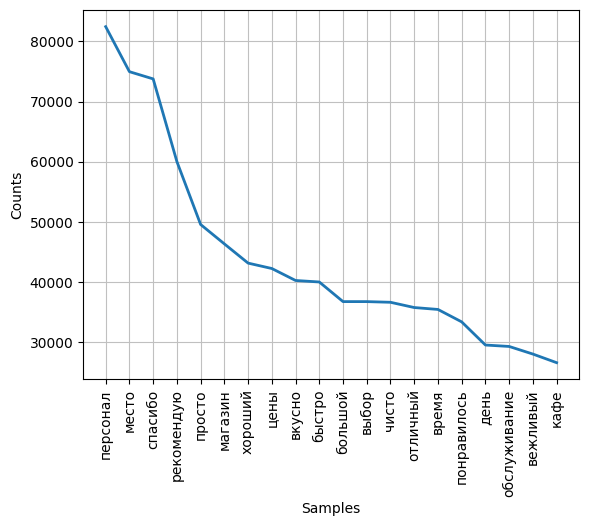

In [33]:
fdist.plot(20,cumulative=False)

## Составим облако слов

In [34]:
wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(fdist)

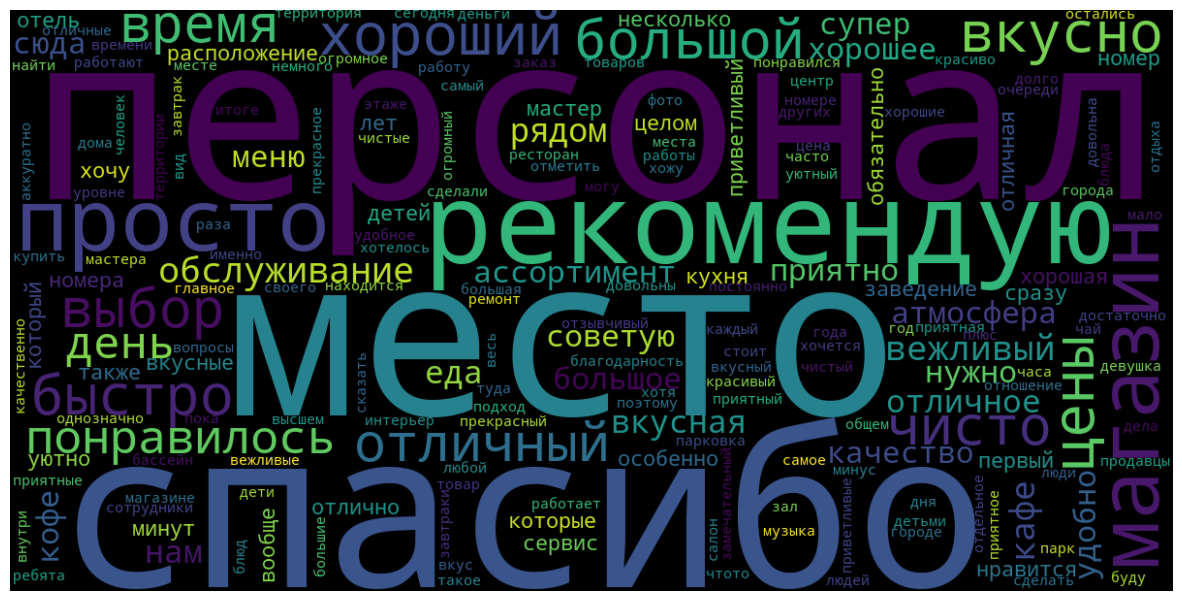

In [35]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

В итоге, нам необходимо удалить строки со слишком большой и маленькой длинной текста, дубликаты, пропущенные значения. Также необходимо сделать баланс классов